In [638]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [639]:
model = BabyMAKROModelClass(name='baseline') # create an instance of the model

In [640]:
par = model.par
ss = model.ss
sol = model.sol

# Find steady state

In [641]:
model.find_ss(0.50,do_print=True)

ss.S = 7.44
ss.L = 56.28
ss.delta_L = 0.07
ss.v = 16.52
ss.m_v = 0.23
ss.r_K = 0.14
ss.r_ell = 2.71
ss.ell = 55.87
ss.w = 2.68
solving for household behavior: result.converged = True
ss.C = 169.41
ss.B = 464.97
ss.K = 557.43
ss.I = 55.74
ss.Y = 229.56
ss.X = 124.57
ss.M = 120.16
par.phi = 0.988


**Household behavior:**

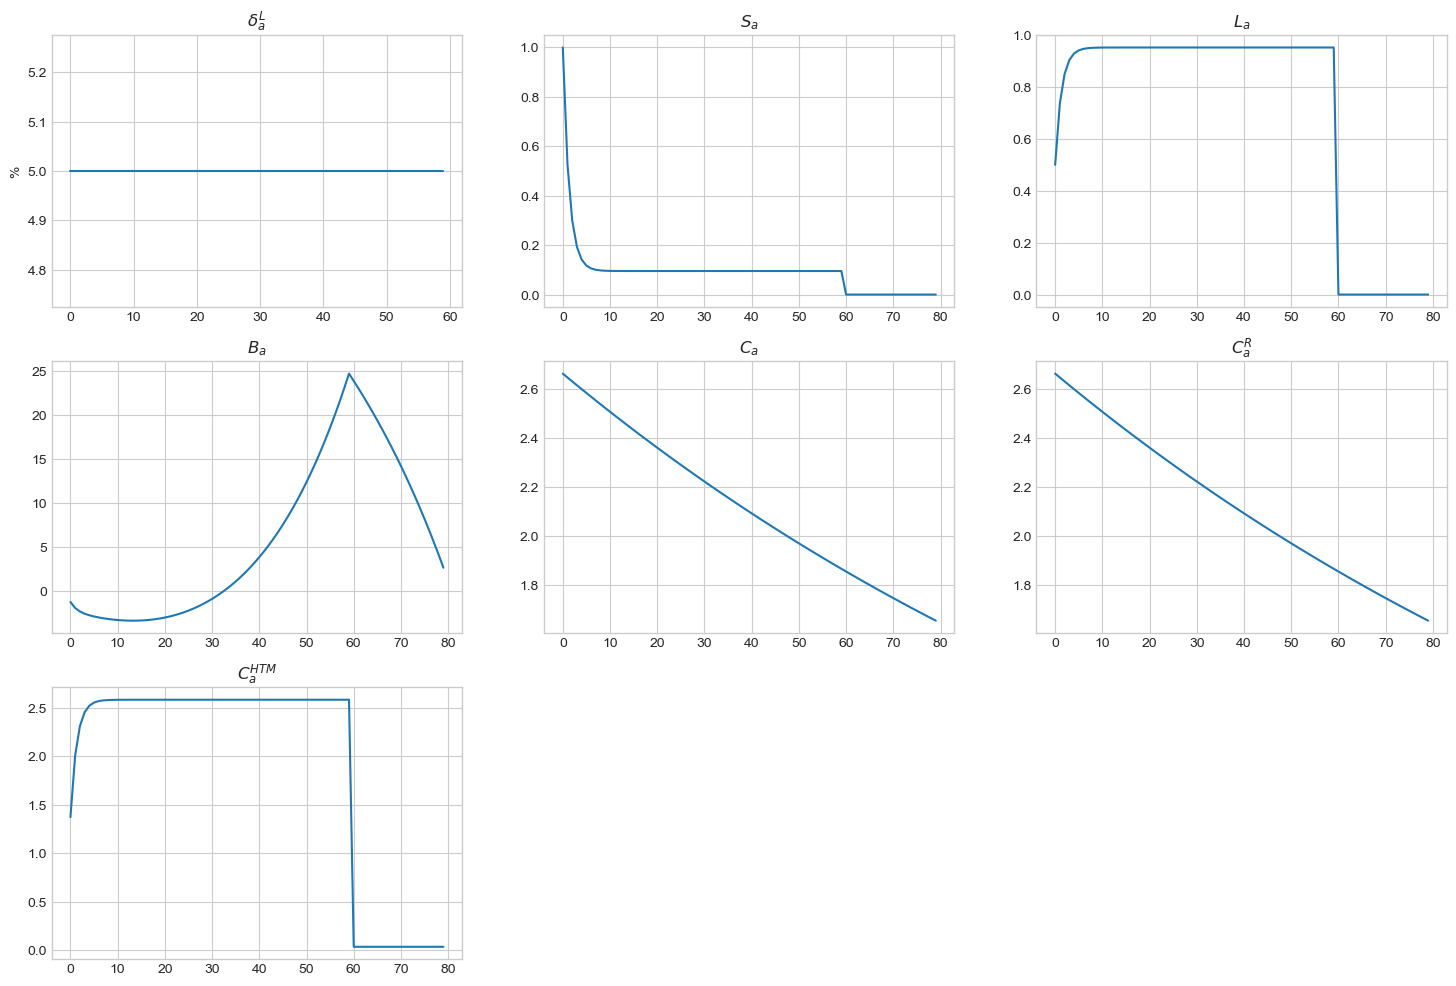

In [642]:
fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot(model.par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('$\delta^L_a$')

ax = fig.add_subplot(3,3,2)
ax.plot(model.ss.S_a)
ax.set_title('$S_a$')

ax = fig.add_subplot(3,3,3)
ax.plot(model.ss.L_a)
ax.set_title('$L_a$')

ax = fig.add_subplot(3,3,4)
ax.plot(model.ss.B_a)
ax.set_ylabel('')
ax.set_title('$B_a$')

ax = fig.add_subplot(3,3,5)
ax.plot(model.ss.C_a)
ax.set_ylabel('')
ax.set_title('$C_a$')

ax = fig.add_subplot(3,3,6)
ax.plot(model.ss.C_R)
ax.set_ylabel('')
ax.set_title('$C^R_a$')

ax = fig.add_subplot(3,3,7)
ax.plot(model.ss.C_HTM)
ax.set_ylabel('')
ax.set_title('$C^{HTM}_a$');

# Speed and error tests

In [643]:
model.set_exo_ss()
model.set_unknowns_ss()

**Python evaluation:**

In [644]:
%time model.evaluate_blocks(py=True)

CPU times: total: 1.39 s
Wall time: 1.4 s


**Check errors:**

In [645]:
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 2.94e-12
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 7.11e-15
mkt_clearing        : abs. max = 8.53e-14


**First numba evaluation:**

In [646]:
%time model.evaluate_blocks()

CPU times: total: 18.9 s
Wall time: 19 s


**Time:**

In [647]:
%timeit model.evaluate_blocks()
%timeit model.get_errors()

16.3 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
23.1 µs ± 133 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [648]:
%timeit model.evaluate_blocks(py=True)

208 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Find an impulse-response

**Calculate Jacobian:**

In [649]:
model.calc_jac(do_print=True)

Jacobian calculated in 39.9 secs secs


Only needs to be calculated once.

**Set exogenous variables:**

In [650]:
model.set_exo_ss()

Here we shock export demand:

In [651]:
Tshock = 50
shock = 0.01*ss.chi
persistence = 0.8**np.arange(Tshock)
sol.chi[:Tshock] = ss.chi + shock*persistence

Check errors when guessing at steady state -> excess demand

In [652]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 4.03e-12
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 8.88e-15
mkt_clearing        : abs. max = 7.47e-01


**Find IRF:**

In [653]:
model.find_IRF()

initial:
   max. abs. error = 7.47e-01
    0.00e+00 in bargaining_cond
    4.03e-12 in Bq_match
    0.00e+00 in FOC_capital_agency
    8.88e-15 in FOC_K_ell
    7.47e-01 in mkt_clearing

it = 0
 solve: t1-t0 = 0.1 secs
   max. abs. error = 7.47e-01
    4.57e-06 in bargaining_cond
    2.09e-02 in Bq_match
    5.43e-06 in FOC_capital_agency
    3.30e-04 in FOC_K_ell
    7.24e-03 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 1
 solve: t1-t0 = 0.1 secs
   max. abs. error = 2.09e-02
    5.19e-08 in bargaining_cond
    2.34e-04 in Bq_match
    3.00e-07 in FOC_capital_agency
    5.19e-06 in FOC_K_ell
    9.11e-05 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 2
 solve: t1-t0 = 0.1 secs
   max. abs. error = 2.34e-04
    4.37e-10 in bargaining_cond
    1.24e-06 in Bq_match
    1.95e-08 in FOC_capital_agency
    3.62e-07 in FOC_K_ell
    6.78e-06 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 3
 s

**Plot:**

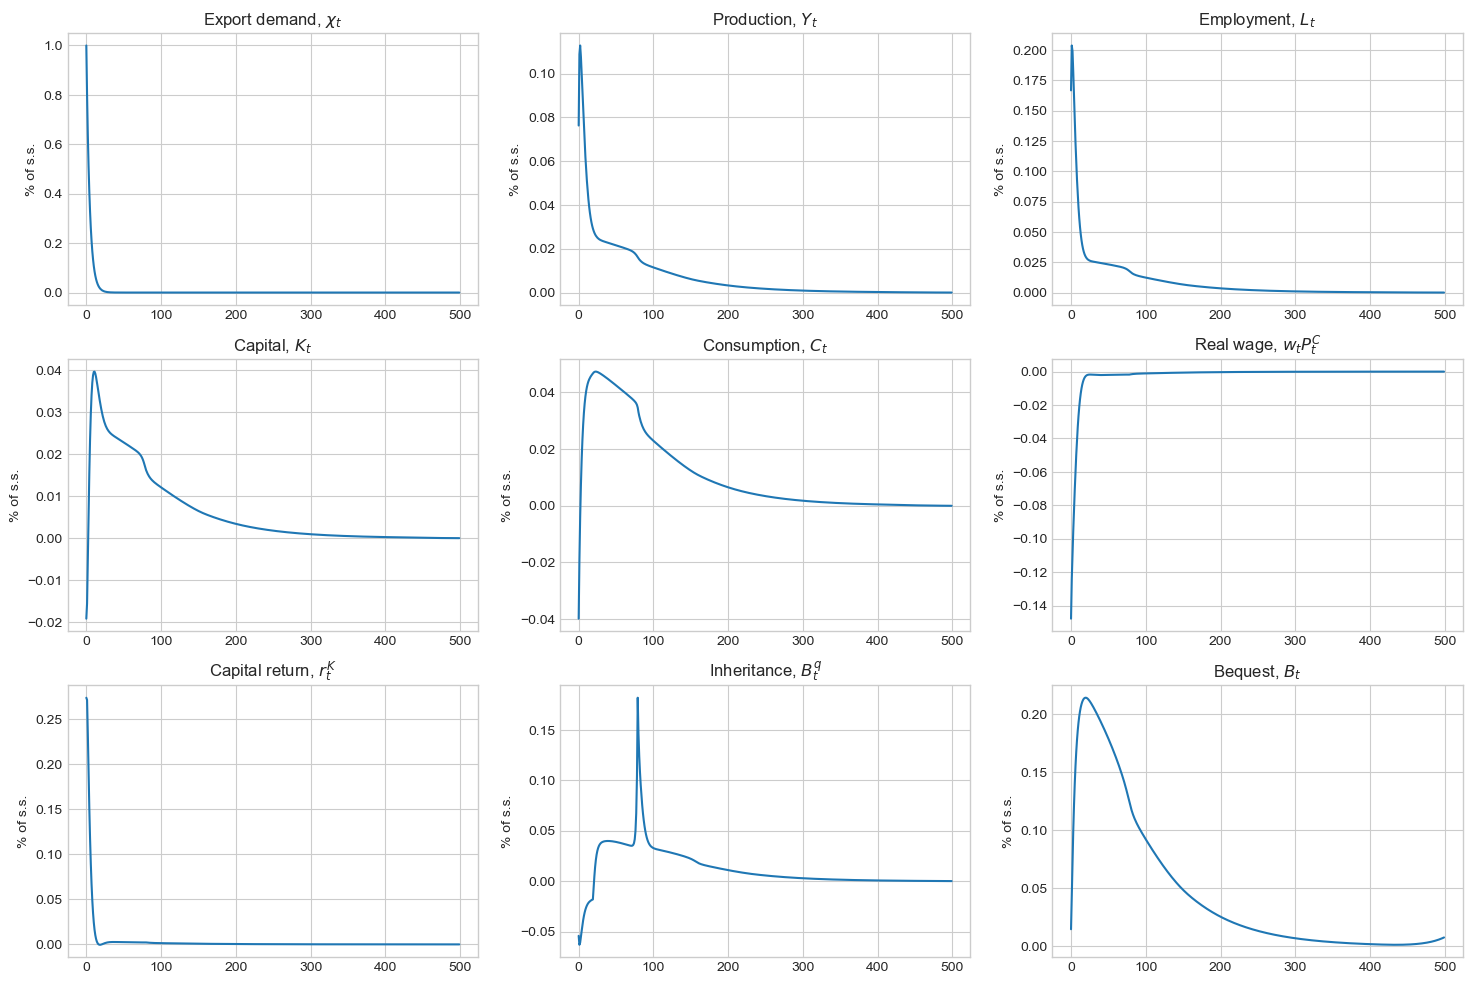

In [654]:
T_IRF = 500

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand, $\chi_t$')

ax = fig.add_subplot(3,3,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(3,3,3)
ax.plot((sol.L[:T_IRF]/ss.L-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Employment, $L_t$')

ax = fig.add_subplot(3,3,4)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(3,3,5)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(3,3,6)
ax.plot(((sol.w[:T_IRF]/sol.P_C[:T_IRF])/(ss.w/ss.P_C)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Real wage, $w_tP^C_t$')

ax = fig.add_subplot(3,3,7)
ax.plot((sol.r_K[:T_IRF]/(ss.r_K)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital return, $r^K_t$')

ax = fig.add_subplot(3,3,8)
ax.plot((sol.Bq[:T_IRF]/(ss.Bq)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Inheritance, $B^q_t$')

ax = fig.add_subplot(3,3,9)
ax.plot((sol.B[:T_IRF]/(ss.B)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Bequest, $B_t$');

In [655]:
sol.Bq[59:100]

array([2.61346452, 2.61345923, 2.61345386, 2.61344841, 2.61344289,
       2.61343731, 2.61343169, 2.61342607, 2.61342055, 2.61341527,
       2.61341059, 2.61340723, 2.61340671, 2.6134122 , 2.61343033,
       2.61347494, 2.61357496, 2.6137909 , 2.61424915, 2.61521392,
       2.61723749, 2.61630463, 2.61573677, 2.61532049, 2.61498289,
       2.614698  , 2.61445516, 2.61424862, 2.61407416, 2.61392805,
       2.61380681, 2.61370713, 2.61362592, 2.61356035, 2.61350785,
       2.61346613, 2.61343317, 2.61340723, 2.61338681, 2.61337065,
       2.61335775])

In [656]:
sol.B_a[-1][59:100]

array([2.61346452, 2.61345923, 2.61345386, 2.61344841, 2.61344289,
       2.61343731, 2.61343169, 2.61342607, 2.61342055, 2.61341527,
       2.61341059, 2.61340723, 2.61340671, 2.6134122 , 2.61343033,
       2.61347494, 2.61357496, 2.6137909 , 2.61424915, 2.61521392,
       2.61723749, 2.61630463, 2.61573677, 2.61532049, 2.61498289,
       2.614698  , 2.61445516, 2.61424862, 2.61407416, 2.61392805,
       2.61380681, 2.61370713, 2.61362592, 2.61356035, 2.61350785,
       2.61346613, 2.61343317, 2.61340723, 2.61338681, 2.61337065,
       2.61335775])

In [659]:
sol.Bq_match[59:100]

array([ 6.62581101e-13, -2.12008189e-12, -7.10542736e-15,  3.95239397e-13,
       -1.58273394e-12,  1.06137321e-13, -4.17754720e-12, -2.08499884e-12,
       -3.06865644e-13, -1.71418435e-12, -5.07149878e-13,  1.85851334e-12,
        2.20268248e-12,  1.45217172e-13, -1.44284584e-12, -2.15072404e-12,
       -6.02495831e-12,  1.96553884e-12, -1.84474658e-12, -4.00568467e-12,
       -2.03659312e-12,  7.23510141e-12, -1.36823886e-12,  5.26378940e-12,
       -6.79589718e-12, -1.31317179e-12, -2.13873363e-12,  6.98685554e-12,
       -2.54818389e-12, -2.35722553e-12, -1.01163522e-12, -1.01563202e-12,
       -1.86073379e-13,  1.42375001e-12,  1.93711713e-12,  3.91908728e-12,
       -3.71658260e-12, -5.38680212e-12, -1.05071507e-12, -1.36202161e-12,
        5.88418203e-13])